In [1]:
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

prefix = "object-detection-crowdai/"
filename = prefix + "labels.csv"

data_frame = pd.read_csv(filename)
print(data_frame.head(3))
print(data_frame.describe(include='all'))


   xmin  xmax  ymin  ymax                    Frame Label  \
0   785   533   905   644  1479498371963069978.jpg   Car   
1    89   551   291   680  1479498371963069978.jpg   Car   
2   268   546   383   650  1479498371963069978.jpg   Car   

                                         Preview URL  
0  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
1  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
2  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
                xmin          xmax          ymin          ymax  \
count   72064.000000  72064.000000  72064.000000  72064.000000   
unique           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN   
mean      817.413480    545.538008    953.902795    659.259200   
std       473.697446     50.185818    483.849802     92.350372   
min         0.000000      0.000000     15.000000      0.000000   
25%       4

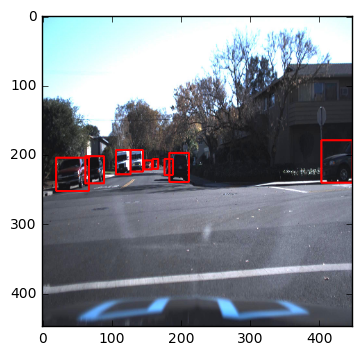

In [2]:
mini_frame = data_frame.loc[0:8]
frame = mini_frame.loc[0]['Frame']
image = mpimg.imread(prefix+frame)

height, width = image.shape[0:2]

new_height = 448.0
new_width = 448.0

image = cv2.resize(image, (448, 448))

for index, row in mini_frame.iterrows():
    frame = row['Frame']
    xmin, xmax, ymin, ymax = row['xmin'], row['xmax'], row['ymin'], row['ymax']

    left_x, left_y, right_x, right_y = int(xmin*new_width/width), int(xmax*new_height/height),\
                                    int(ymin*new_width/width), int(ymax*new_height/height)

    left = (left_x, left_y)
    right = (right_x, right_y)

    cv2.rectangle(image, left, right, [255,0,0], thickness=2)

plt.imshow(image)

In [8]:
S = 7
SS = S*S
import math

def find_cell_number(centroid_x, centroid_y):
    delta = 448.0/7
    for i in range(SS):
        x_d = i%S
        y_d = i//S
        x_in_limit = delta*(x_d) <= centroid_x <= delta*(x_d + 1)
        y_in_limit = delta*(y_d) <= centroid_y <= delta*(y_d + 1)
        
        if x_in_limit and y_in_limit:
            return i
        

def compute_ground_truth_yolo_output(left, right, yolo_output=None):
    image_width, image_height = 448.0, 448.0
    delta = image_height/S
    
    width = abs(right[0] - left[0])/image_width
    w = math.sqrt(width)
    
    height = abs(right[1] - left[1])/image_height
    h = math.sqrt(height)
    
    centroid_x = (left[0] + right[0])/2
    centroid_y = (left[1] + right[1])/2
    
    cell_number = find_cell_number(centroid_x, centroid_y)
    
    x_d = (cell_number%S)*delta
    y_d = (cell_number//S)*delta
    
    x = (centroid_x - x_d)/delta
    y = (centroid_y - y_d)/delta
    
    if yolo_output is None:
        yolo_output = np.zeros((294,), dtype=np.float32)
    
    # class probability
    yolo_output[cell_number] = 1.0
    
    # confidence score
    yolo_output[SS+cell_number] = 1.0
    
    # vertices
    vertices_index = 2*SS + 4*cell_number
    
    yolo_output[vertices_index] = x
    yolo_output[vertices_index+1] = y
    yolo_output[vertices_index+2] = w
    yolo_output[vertices_index+3] = h
    
    return yolo_output

In [4]:
class Box:
    def __init__(self):
        self.x, self.y = 0.0, 0.0
        self.w, self.h = 0.0, 0.0
        self.c = 0.0
        self.prob = 0.0


def overlap(x1, w1, x2, w2):
    l1 = x1 - w1 / 2.
    l2 = x2 - w2 / 2.
    left = max(l1, l2)
    r1 = x1 + w1 / 2.
    r2 = x2 + w2 / 2.
    right = min(r1, r2)
    return right - left


def box_intersection(a, b):
    """

    :param a: Box 1
    :param b: Box 2
    :return: Intersection area of the 2 boxes
    """
    w = overlap(a.x, a.w, b.x, b.w)
    h = overlap(a.y, a.h, b.y, b.h)
    if w < 0 or h < 0:
        return 0
    area = w * h
    return area


def box_union(a, b):
    """

    :param a: Box 1
    :param b: Box 2
    :return: Area under the union of the 2 boxes
    """
    i = box_intersection(a, b)
    u = a.w * a.h + b.w * b.h - i
    return u


def box_iou(a, b):
    """

    :param a: Box 1
    :param b: Box 2
    :return: Intersection over union, which is ratio of intersection area to union area of the 2 boxes
    """
    return box_intersection(a, b) / box_union(a, b)

In [5]:
def yolo_output_to_car_boxes(yolo_output, threshold=0.2, sqrt=2.0, C=1, B=1, S=7):
    # Position for class 'car' in the VOC dataset classes
    car_class_number = 0
    
    delta = 448.0/S

    boxes = []
    SS = S * S  # number of grid cells
    prob_size = SS * C  # class probabilities
    conf_size = SS * B  # confidences for each grid cell

    probabilities = yolo_output[0:prob_size]
    confidence_scores = yolo_output[prob_size: (prob_size + conf_size)]
    cords = yolo_output[(prob_size + conf_size):]

    # Reshape the arrays so that its easier to loop over them
    probabilities = probabilities.reshape((SS, C))
    confs = confidence_scores.reshape((SS, B))
    cords = cords.reshape((SS, B, 4))

    for grid in range(SS):
        for b in range(B):
            bx = Box()

            bx.c = confs[grid, b]
            
            # multiply confidence scores with class probabilities to get class sepcific confidence scores
            p = probabilities[grid, :] * bx.c

            # Check if the confidence score for class 'car' is greater than the threshold
            if p[car_class_number] >= threshold:
                bx.prob = p[car_class_number]
                
                # bounding box xand y coordinates are offsets of a particular grid cell location,
                # so they are also bounded between 0 and 1.
                # convert them absolute locations relative to the image size
                bx.x = (cords[grid, b, 0] + grid % S)*delta
                bx.y = (cords[grid, b, 1] + grid // S)*delta

                bx.w = (cords[grid, b, 2] ** sqrt)*448.0
                bx.h = (cords[grid, b, 3] ** sqrt)*448.0
                
                boxes.append(bx)
                
    # sort the boxes by confidence score, in the descending order
    boxes.sort(key=lambda b: b.prob, reverse=True)

    for i in range(len(boxes)):
        boxi = boxes[i]
        if boxi.prob == 0:
            continue

        for j in range(i + 1, len(boxes)):
            boxj = boxes[j]

            # If boxes have more than 40% overlap then retain the box with the highest confidence score
            if box_iou(boxi, boxj) >= 0.4:
                boxes[j].prob = 0

    boxes = [b for b in boxes if b.prob > 0]

    return boxes

In [11]:
def draw_boxes(boxes, im):
    imgcv1 = im.copy()

    height, width = 448, 448
    for b in boxes:

        left = int((b.x - b.w / 2.))
        right = int((b.x + b.w / 2.))
        top = int((b.y - b.h / 2.))
        bot = int((b.y + b.h / 2.))

        if left < 0:
            left = 0
        if right > width - 1:
            right = width - 1
        if top < 0:
            top = 0
        if bot > height - 1:
            bot = height - 1

        cv2.rectangle(imgcv1, (left, top), (right, bot), (255, 0, 0), 2)

    return imgcv1

(294,) 0.0 1.0
1
197.0 219.0 28.0 42.0000030569 1.0 1.0


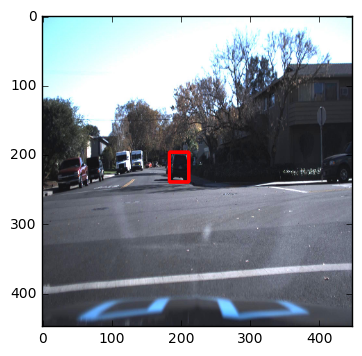

In [9]:
row = mini_frame.loc[0]
frame = row['Frame']
image = mpimg.imread(prefix+frame)

height, width = image.shape[0:2]

new_height = 448.0
new_width = 448.0

image = cv2.resize(image, (448, 448))


frame = row['Frame']
xmin, xmax, ymin, ymax = row['xmin'], row['xmax'], row['ymin'], row['ymax']

left_x, left_y, right_x, right_y = int(xmin*new_width/width), int(xmax*new_height/height),\
                                int(ymin*new_width/width), int(ymax*new_height/height)

left = (left_x, left_y)
right = (right_x, right_y)

# centroid_x = (left[0] + right[0])/2
# centroid_y = (left[1] + right[1])/2
    
# cell_number = find_cell_number(centroid_x, centroid_y)

# delta = 448.0/S

# x_d = (cell_number % S)*delta
# y_d = (cell_number// S)*delta

# left = (int(x_d), int(y_d))
# right = (int(x_d + delta), int(y_d+delta))

# cv2.rectangle(image, left, right, (255, 0, 0), 3)

# print(cell_number)

# plt.imshow(image)

yolo_output = compute_ground_truth_yolo_output(left, right)

print(yolo_output.shape, np.min(yolo_output), np.max(yolo_output) )

boxes = yolo_output_to_car_boxes(yolo_output)

print(len(boxes))

box = boxes[0]

print(box.x, box.y, box.w, box.h, box.c, box.prob)

output_image = draw_boxes(boxes, image)

plt.imshow(output_image)

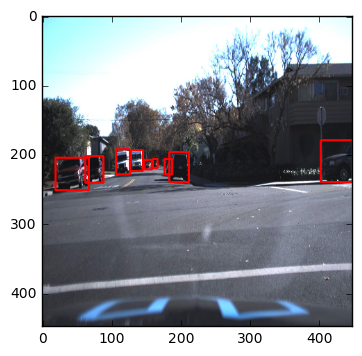

In [62]:
YO = np.zeros((294,), dtype=np.float32)

mini_frame = data_frame.loc[0:8]
frame = mini_frame.loc[0]['Frame']
image = mpimg.imread(prefix+frame)

height, width = image.shape[0:2]

new_height = 448.0
new_width = 448.0

image = cv2.resize(image, (448, 448))

boxes = []

for index, row in mini_frame.iterrows():
    frame = row['Frame']
    xmin, xmax, ymin, ymax = row['xmin'], row['xmax'], row['ymin'], row['ymax']

    left_x, left_y, right_x, right_y = int(xmin*new_width/width), int(xmax*new_height/height),\
                                    int(ymin*new_width/width), int(ymax*new_height/height)

    left = (left_x, left_y)
    right = (right_x, right_y)

    YO = compute_ground_truth_yolo_output(left, right, YO)

    boxes += yolo_output_to_car_boxes(YO)

image = draw_boxes(boxes, image)

plt.imshow(image)

In [12]:
print(row['Preview URL'])

http://crowdai.com/images/Wwj-gorOCisE7uxA/visualize


In [68]:
frame = ''

new_data_frame = None

YO = None

for index, row in data_frame.iterrows():
    if not frame:
        frame = row['Frame']
    elif frame == row['Frame']:
        pass
    else:
        # add row to data frame
        df = pd.DataFrame([YO], index=[frame])
        if new_data_frame is not None:
            new_data_frame = new_data_frame.append(df)
        else:
            new_data_frame = df
        frame = row['Frame']
        YO = None
    
    xmin, xmax, ymin, ymax = row['xmin'], row['xmax'], row['ymin'], row['ymax']

    left_x, left_y, right_x, right_y = int(xmin*new_width/width), int(xmax*new_height/height),\
                                    int(ymin*new_width/width), int(ymax*new_height/height)

    left = (left_x, left_y)
    right = (right_x, right_y)

    YO = compute_ground_truth_yolo_output(left, right, YO)

In [73]:
new_data_frame.to_csv("new_data.csv")
# npa = new_data_frame.loc['1479498371963069978.jpg'].values
# np.sum(npa[0:49])

1479498371963069978.jpg
(294,) 5.0
5


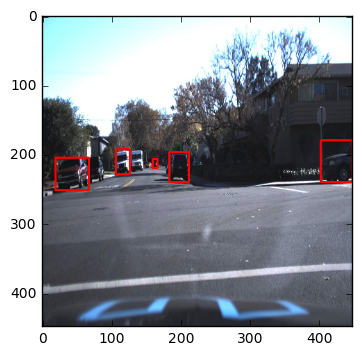

In [61]:
YO = np.zeros((294,), dtype=np.float32)

image = cv2.resize(image, (448, 448))

boxes = []

frame = ""
for index, row in new_data_frame.iterrows():
    if not frame:
        frame = index
        print(frame)
        image = mpimg.imread(prefix+frame)
        image = cv2.resize(image, (448, 448))
        height, width = image.shape[0:2]
        new_height = 448.0
        new_width = 448.0
    elif frame != index:
        break
        
    YO = np.asarray(row.values)
    
    print(YO.shape, np.sum(YO[0:49]))

    boxes += yolo_output_to_car_boxes(YO)
    
print(len(boxes))

image = draw_boxes(boxes, image)

plt.imshow(image)